In [8]:
%matplotlib inline
#Reference from https://pytorch.org/

In [9]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
'''
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize([224, 224]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '../AddMoreData061823/Class3Type2/TTV'
l = []
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
#l.append(datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test']))
image_datasetss = torch.utils.data.ConcatDataset(l)
image_datasets = {}
image_datasets['train'] = image_datasetss
image_datasets['test'] = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['test'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
class_names = image_datasets['test'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(len( image_datasets['train']))
print(len( image_datasets['val']))
print(len( image_datasets['test']))

['0', '1', '2']
204
7
7


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



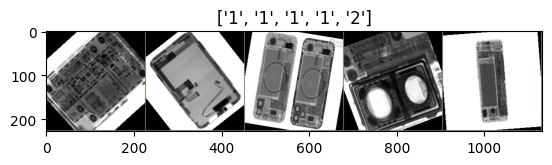

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs+1):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(outputs)
                    #print(labels)
                    loss = criterion(outputs, labels)
    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            m = nn.Softmax(dim=1)
            proOutput = m(outputs)
            pros = proOutput.detach().cpu().numpy()
            #print(pros)
            #_, preds = torch.max(outputs, 1)
            #pro = torch.max(proOutput, dim=1)[0]
            #_, predsmin = torch.min(outputs, 1)
            #promin = torch.min(proOutput, dim=1)[0]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #ax.set_title('predicted: %s with %s probabilities' %(class_names[preds[j]], round(pro[j].item(),4)))
                print('Actual label: %s' %(class_names[labels[j].item()]))
                for jj in range(3):
                    print('predicted: %s with %s probabilities' %(class_names[jj], round(pros[j][jj],4)))
                #print('predicted: %s with %s probabilities' %(class_names[1], round(pros[j][1],4)))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

#visualize_model(model_ft)

In [14]:
model_ft = models.resnet50(pretrained=True) #load googlenet.

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\haoyuliao/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
24.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

64.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [15]:
ep = 100
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=ep)

Epoch 1/100
----------
train Loss: 0.6491 Acc: 0.7843
val Loss: 1.0744 Acc: 0.5714

Epoch 2/100
----------
train Loss: 0.4834 Acc: 0.8186
val Loss: 1.1502 Acc: 0.5714

Epoch 3/100
----------
train Loss: 0.3368 Acc: 0.8873
val Loss: 1.9566 Acc: 0.5714

Epoch 4/100
----------
train Loss: 0.2531 Acc: 0.8971
val Loss: 1.9466 Acc: 0.5714

Epoch 5/100
----------
train Loss: 0.1489 Acc: 0.9657
val Loss: 2.7451 Acc: 0.5714

Epoch 6/100
----------
train Loss: 0.0894 Acc: 0.9657
val Loss: 2.7834 Acc: 0.5714

Epoch 7/100
----------
train Loss: 0.0957 Acc: 0.9657
val Loss: 2.0166 Acc: 0.5714

Epoch 8/100
----------
train Loss: 0.0588 Acc: 0.9951
val Loss: 2.0051 Acc: 0.5714

Epoch 9/100
----------
train Loss: 0.0723 Acc: 0.9853
val Loss: 2.0294 Acc: 0.5714

Epoch 10/100
----------
train Loss: 0.0797 Acc: 0.9755
val Loss: 2.0910 Acc: 0.4286

Epoch 11/100
----------
train Loss: 0.1129 Acc: 0.9706
val Loss: 1.9651 Acc: 0.5714

Epoch 12/100
----------
train Loss: 0.0354 Acc: 0.9951
val Loss: 2.1334 Ac

val Loss: 2.0239 Acc: 0.5714

Epoch 98/100
----------
train Loss: 0.0558 Acc: 0.9853
val Loss: 2.0515 Acc: 0.7143

Epoch 99/100
----------
train Loss: 0.0498 Acc: 0.9853
val Loss: 2.1859 Acc: 0.5714

Epoch 100/100
----------
train Loss: 0.0679 Acc: 0.9902
val Loss: 2.1078 Acc: 0.5714

Epoch 101/100
----------
train Loss: 0.0384 Acc: 0.9951
val Loss: 2.1484 Acc: 0.5714

Training complete in 10m 23s
Best val Acc: 0.714286


Actual label: 1
predicted: 0 with 0.1065 probabilities
predicted: 1 with 0.3318 probabilities
predicted: 2 with 0.5617 probabilities


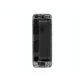

Actual label: 1
predicted: 0 with 0.0005 probabilities
predicted: 1 with 0.9994 probabilities
predicted: 2 with 0.0002 probabilities


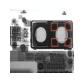

Actual label: 2
predicted: 0 with 0.0056 probabilities
predicted: 1 with 0.3202 probabilities
predicted: 2 with 0.6742 probabilities


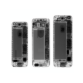

Actual label: 0
predicted: 0 with 0.896 probabilities
predicted: 1 with 0.0181 probabilities
predicted: 2 with 0.0859 probabilities


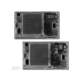

Actual label: 1
predicted: 0 with 0.0663 probabilities
predicted: 1 with 0.812 probabilities
predicted: 2 with 0.1218 probabilities


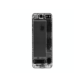

Actual label: 0
predicted: 0 with 0.6888 probabilities
predicted: 1 with 0.1971 probabilities
predicted: 2 with 0.1141 probabilities


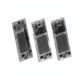

Actual label: 1
predicted: 0 with 0.3222 probabilities
predicted: 1 with 0.5115 probabilities
predicted: 2 with 0.1662 probabilities


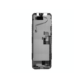

In [16]:
visualize_model(model_ft, 10)

In [17]:
correct = 0
total = 0
nb_classes = 3
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['train']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s train images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 204 train images: 100 %
tensor([[ 32.,   0.,   0.],
        [  0., 160.,   0.],
        [  0.,   0.,  12.]])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [18]:
correct = 0
total = 0
nb_classes = 3
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s val images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 7 val images: 71 %
tensor([[0., 1., 1.],
        [0., 4., 0.],
        [0., 0., 1.]])
tensor([[0.0000, 0.5000, 0.5000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000]])


In [19]:
correct = 0
total = 0
nb_classes = 3
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s test images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 7 test images: 85 %
tensor([[2., 0., 0.],
        [0., 3., 1.],
        [0., 0., 1.]])
tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.7500, 0.2500],
        [0.0000, 0.0000, 1.0000]])


In [20]:
if not os.path.exists('trained models'):
   os.makedirs('trained models')
PATH = './trained models/ResNetXray-TTVClass3-BestEP%s.pth' %(ep)
torch.save(model_ft.state_dict(), PATH)